In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip '/content/drive/MyDrive/archive (7).zip' -d '/content/cancerdata/'

Streaming output truncated to the last 5000 lines.
  inflating: /content/cancerdata/data/train/benign/420.jpg  
  inflating: /content/cancerdata/data/train/benign/421.jpg  
  inflating: /content/cancerdata/data/train/benign/422.jpg  
  inflating: /content/cancerdata/data/train/benign/423.jpg  
  inflating: /content/cancerdata/data/train/benign/424.jpg  
  inflating: /content/cancerdata/data/train/benign/425.jpg  
  inflating: /content/cancerdata/data/train/benign/426.jpg  
  inflating: /content/cancerdata/data/train/benign/429.jpg  
  inflating: /content/cancerdata/data/train/benign/43.jpg  
  inflating: /content/cancerdata/data/train/benign/430.jpg  
  inflating: /content/cancerdata/data/train/benign/431.jpg  
  inflating: /content/cancerdata/data/train/benign/432.jpg  
  inflating: /content/cancerdata/data/train/benign/434.jpg  
  inflating: /content/cancerdata/data/train/benign/435.jpg  
  inflating: /content/cancerdata/data/train/benign/438.jpg  
  inflating: /content/cancerdata/da

In [ ]:
import glob
import numpy as np
import cv2
from skimage import filters as skifilters
from scipy import ndimage
from skimage import filters
import matplotlib.pyplot as plt
import tqdm
from sklearn.utils import shuffle
import pandas as pd
from __future__ import unicode_literals
from __future__ import print_function
from __future__ import division
from __future__ import absolute_import
import os
import h5py
import time
import json
import warnings
from PIL import Image

In [ ]:
def shades_gray(image, njet=0, mink_norm=1, sigma=1):
    """
    Estimates the light source of an input_image as proposed in:
    J. van de Weijer, Th. Gevers, A. Gijsenij
    "Edge-Based Color Constancy"
    IEEE Trans. Image Processing, accepted 2007.
    Depending on the parameters the estimation is equal to Grey-World, Max-RGB, general Grey-World,
    Shades-of-Grey or Grey-Edge algorithm.
    :param image: rgb input image (NxMx3)
    :param njet: the order of differentiation (range from 0-2)
    :param mink_norm: minkowski norm used (if mink_norm==-1 then the max
           operation is applied which is equal to minkowski_norm=infinity).
    :param sigma: sigma used for gaussian pre-processing of input image
    :return: illuminant color estimation
    :raise: ValueError

    Ref: https://github.com/MinaSGorgy/Color-Constancy
    """
    gauss_image = filters.gaussian(image, sigma=sigma, multichannel=True)
    if njet == 0:
        deriv_image = [gauss_image[:, :, channel] for channel in range(3)]
    else:
        if njet == 1:
            deriv_filter = filters.sobel
        elif njet == 2:
            deriv_filter = filters.laplace
        else:
            raise ValueError("njet should be in range[0-2]! Given value is: " + str(njet))
        deriv_image = [np.abs(deriv_filter(gauss_image[:, :, channel])) for channel in range(3)]
    for channel in range(3):
        deriv_image[channel][image[:, :, channel] >= 255] = 0.
    if mink_norm == -1:
        estimating_func = np.max
    else:
        estimating_func = lambda x: np.power(np.sum(np.power(x, mink_norm)), 1 / mink_norm)
    illum = [estimating_func(channel) for channel in deriv_image]
    som   = np.sqrt(np.sum(np.power(illum, 2)))
    illum = np.divide(illum, som)
    return illum

In [ ]:
def correct_image(image, illum):
    """
    Corrects image colors by performing diagonal transformation according to
    given estimated illumination of the image.
    :param image: rgb input image (NxMx3)
    :param illum: estimated illumination of the image
    :return: corrected image

    Ref: https://github.com/MinaSGorgy/Color-Constancy
    """
    correcting_illum = illum * np.sqrt(3)
    corrected_image = image / 255.
    for channel in range(3):
        corrected_image[:, :, channel] /= correcting_illum[channel]
    return np.clip(corrected_image, 0., 1.)

In [ ]:
import os
import cv2
import numpy as np

In [ ]:
os.makedirs('/content/drive/MyDrive/two_tr_final')

In [ ]:
os.makedirs('/content/drive/MyDrive/two_tr_final/ben')


In [ ]:
print(len(os.listdir('/content/cancerdata/data/train/benign')))
print(len(os.listdir('/content/drive/MyDrive/two_tr_final/ben')))

1440
1440


In [ ]:
final_path = '/content/drive/MyDrive/two_train_final/malig'

In [ ]:
import PIL

In [ ]:
image    = plt.imread("/content/drive/MyDrive/pre_two_train/benign/100.jpg")

In [ ]:
for i in os.listdir('/content/cancerdata/data/train/benign'):
    image = plt.imread('/content/cancerdata/data/train/benign/'+i)
    mx    = correct_image(image, shades_gray(image, njet=0, mink_norm=-1, sigma=0))  # MaxRGB Constancy
    gw    = correct_image(image, shades_gray(image, njet=0, mink_norm=+6, sigma=0))  # Gray World Constancy
    hsv   = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)                                   # HSV Color Space
    lab   = cv2.cvtColor(image, cv2.COLOR_RGB2Lab)
    op    = np.concatenate((gw/255,np.expand_dims(hsv[:,:,0]/179,axis=2),hsv[:,:,1:]/255,
                                np.expand_dims(lab[:,:,0]/255,axis=2),lab[:,:,1:]/128),axis=2)
    output = op[:,:,:3]*255
    plt.imsave('/content/drive/MyDrive/two_tr_final/ben/' + str(i) , output)






<ipython-input-4-38f435e1e605>:19: FutureWarning: `multichannel` is a deprecated argument name for `gaussian`. It will be removed in version 1.0. Please use `channel_axis` instead.
  gauss_image = filters.gaussian(image, sigma=sigma, multichannel=True)


In [ ]:
mx    = correct_image(image, shades_gray(image, njet=0, mink_norm=-1, sigma=0))  # MaxRGB Constancy
gw    = correct_image(image, shades_gray(image, njet=0, mink_norm=+6, sigma=0))  # Gray World Constancy
hsv   = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)                                   # HSV Color Space
lab   = cv2.cvtColor(image, cv2.COLOR_RGB2Lab)                                   # CIELab Color Space

        # Concatenate to Output Image
op    = np.concatenate((gw/255,np.expand_dims(hsv[:,:,0]/179,axis=2),hsv[:,:,1:]/255,
                                np.expand_dims(lab[:,:,0]/255,axis=2),lab[:,:,1:]/128),axis=2)



<ipython-input-3-38f435e1e605>:19: FutureWarning: `multichannel` is a deprecated argument name for `gaussian`. It will be removed in version 1.0. Please use `channel_axis` instead.
  gauss_image = filters.gaussian(image, sigma=sigma, multichannel=True)


In [ ]:
print(op.shape)

(450, 600, 9)


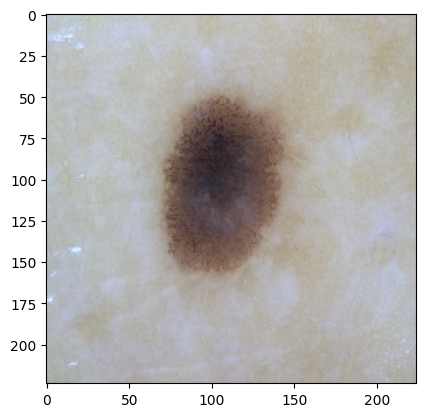

In [ ]:
plt.imshow(op[:,:,:3]*255)


In [ ]:
print(op.shape)

(450, 600, 9)


In [ ]:
ot  = np.concatenate((image,mx,gw,hsv,lab),axis=2)

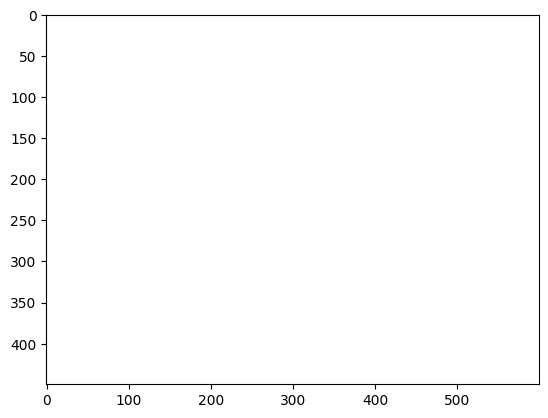

In [ ]:
plt.imshow(ot[:,:,:3]*255)

In [ ]:
circa_mask = create_circular_mask(gw.shape[0], gw.shape[1], radius=200).astype(bool)
gw = np.multiply(gw, np.dstack((circa_mask,circa_mask,circa_mask)))


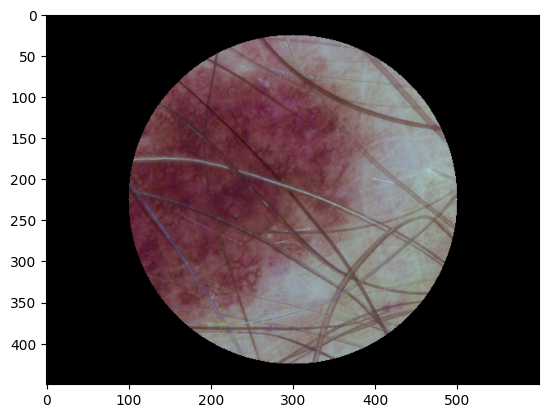

In [ ]:
plt.imshow(gw[:,:,:3])

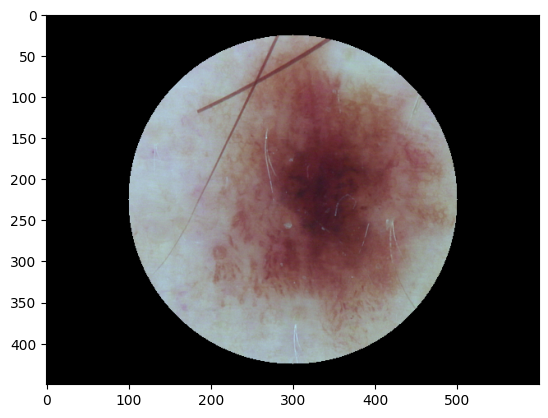

In [ ]:
plt.imshow(gw)

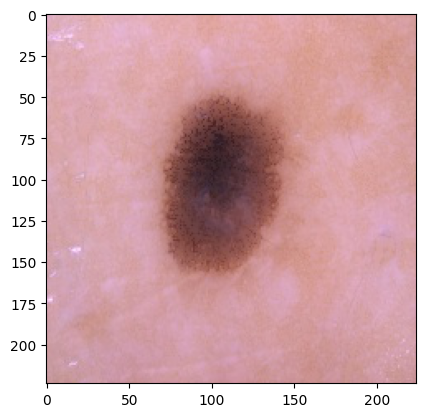

In [ ]:
plt.imshow(image)

In [ ]:
circa_mask = create_circular_mask(op.shape[0], op.shape[1], radius=200).astype(bool)
out = np.multiply(op, np.dstack((circa_mask,circa_mask,circa_mask,circa_mask,circa_mask,
                                                             circa_mask,circa_mask,circa_mask,circa_mask)))

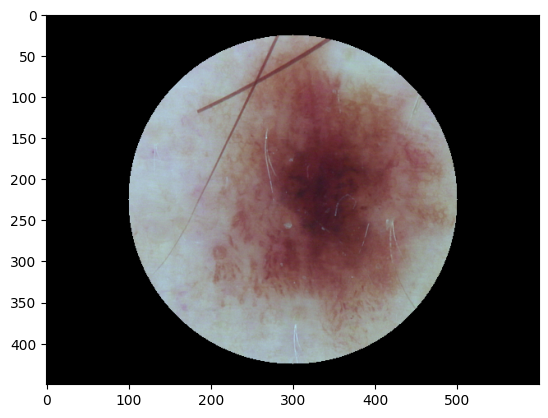

In [ ]:
plt.imshow(out[:,:,:3]*255)